# Machine Learning Models - Heart Disease Risk Prediction

This notebook implements and compares machine learning models for heart disease risk prediction.

**Focus**: Model training, feature selection based on correlation, and performance evaluation


## 1. Load Libraries and Dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load dataset
original_df = pd.read_csv("data/train.csv", delimiter=",")


## 2. Dataset Overview


In [2]:
print(f"Dataset shape: {original_df.shape}")
print(f"Number of features: {original_df.shape[1]}")
print(f"Number of samples: {original_df.shape[0]}")

# Check class balance
target_counts = original_df["TARGET"].value_counts()
print(f"\nClass distribution:")
print(target_counts)
print(f"Positive class ratio: {target_counts[1] / len(original_df):.2%}")


Dataset shape: (225000, 325)
Number of features: 325
Number of samples: 225000

Class distribution:
TARGET
False    204861
True      20139
Name: count, dtype: int64
Positive class ratio: 8.95%


C:\Users\jules\AppData\Local\Temp\ipykernel_77064\2924517679.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Positive class ratio: {target_counts[1] / len(original_df):.2%}")


## 3. Feature Analysis - Missing Values


Features with 100% missing: 3
Features with >90% missing: 97
Features with <10% missing: 105


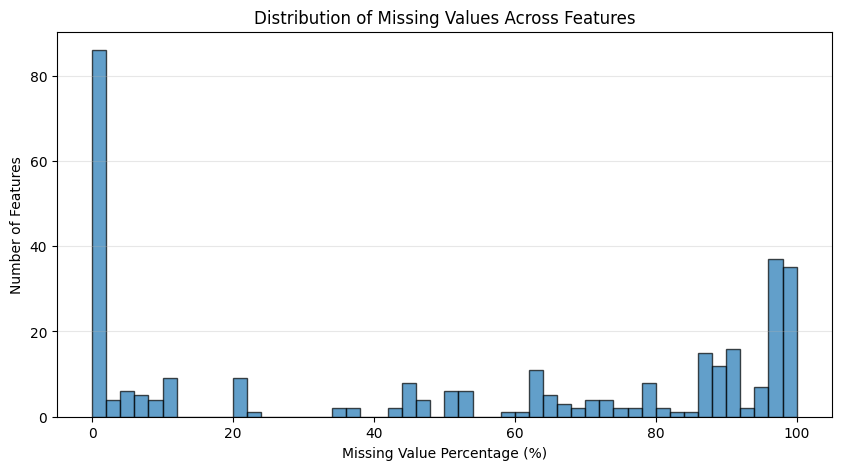

In [3]:
# Calculate missing value percentage per feature
missing_pct = original_df.isna().mean() * 100

# Summary statistics
print(f"Features with 100% missing: {(missing_pct == 100).sum()}")
print(f"Features with >90% missing: {(missing_pct > 90).sum()}")
print(f"Features with <10% missing: {(missing_pct < 10).sum()}")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(missing_pct, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Missing Value Percentage (%)')
plt.ylabel('Number of Features')
plt.title('Distribution of Missing Values Across Features')
plt.grid(axis='y', alpha=0.3)
plt.show()


## 4. Feature Selection - Correlation with Target


In [4]:
target_col = "TARGET"

# Convert to numeric for correlation analysis
df_num = original_df.apply(pd.to_numeric, errors='coerce')

# Compute correlation with target
if target_col in df_num.columns and df_num[target_col].notna().sum() >= 2:
    corr_series = df_num.corr(numeric_only=True)[target_col]
else:
    corr_series = pd.Series(index=df_num.columns, dtype=float)

# Create summary table
summary = pd.DataFrame({
    'feature': original_df.columns,
    '%missing': missing_pct.reindex(original_df.columns).values,
    'corr_with_Target': corr_series.reindex(original_df.columns).values
})

# Remove target itself
summary = summary[summary['feature'] != target_col]

# Sort by missing percentage, then by absolute correlation
summary = summary.sort_values(
    by=['%missing', 'corr_with_Target'],
    ascending=[True, False],
    key=lambda s: (np.abs(s) if s.name == 'corr_with_Target' else s)
).reset_index(drop=True)

# Save for reference
summary.to_csv("features_missing_corr_target.csv", index=False)
print(f"Feature summary saved to features_missing_corr_target.csv")
print(f"\nTop 10 features by correlation:")
print(summary.head(10))


Feature summary saved to features_missing_corr_target.csv

Top 10 features by correlation:
    feature  %missing  corr_with_Target
0    _AGE80       0.0          0.231371
1  _AGEG5YR       0.0          0.222521
2    _AGE_G       0.0          0.214506
3  _HCVU652       0.0          0.194126
4  _AGE65YR       0.0          0.184403
5   _RFHLTH       0.0          0.152469
6    QSTVER       0.0         -0.101399
7  _PHYS14D       0.0          0.099125
8  _EXTETH3       0.0          0.083966
9  _DUALUSE       0.0         -0.083210


In [5]:
# Filter features with |correlation| > 0.1
filtered_summary = summary[summary['corr_with_Target'].abs() > 0.1]
filtered_summary = filtered_summary.sort_values(by='corr_with_Target', ascending=False).reset_index(drop=True)

print(f"✓ Features with |corr(Target)| > 0.1: {len(filtered_summary)}")
print(filtered_summary)


✓ Features with |corr(Target)| > 0.1: 23
     feature   %missing  corr_with_Target
0     _AGE80   0.000000          0.231371
1   _AGEG5YR   0.000000          0.222521
2    GENHLTH   0.000444          0.222041
3     _AGE_G   0.000000          0.214506
4   COLGSEX1  99.993778          0.206725
5    EMPLOY1   1.439111          0.203364
6   _HCVU652   0.000000          0.194126
7   _AGE65YR   0.000000          0.184403
8   _PACKYRS  67.582667          0.168462
9   _YRSSMOK  66.520444          0.161509
10   _RFHLTH   0.000000          0.152469
11  _PACKDAY  65.851111          0.121894
12  CRVCLCNC  69.981778          0.105677
13  CHILDREN   2.155556          0.105020
14    QSTVER   0.000000         -0.101399
15  _SMOKGRP   8.182222         -0.115289
16  HAVARTH4   0.000444         -0.126937
17  DIFFWALK   5.084444         -0.129064
18  RMVTETH4   0.450667         -0.129525
19  RESPSLCT  88.496889         -0.139966
20  COPDBRTH  97.591111         -0.146857
21  DIABETE4   0.000444         -0.

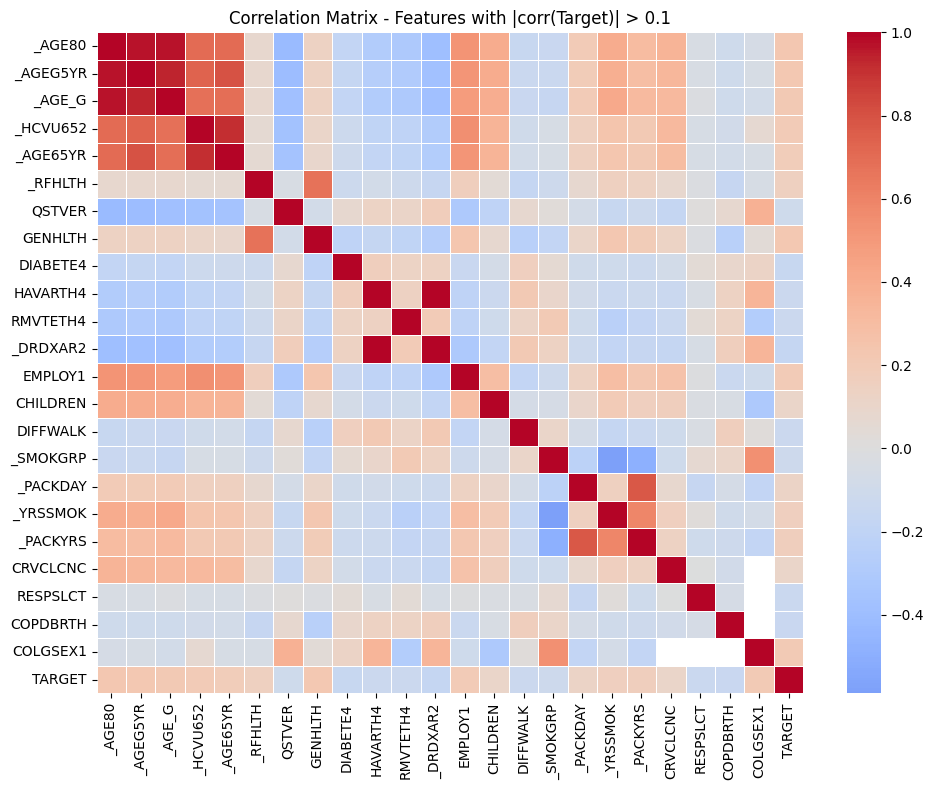

In [6]:
# Visualize correlation matrix of selected features
selected_features = summary.loc[summary['corr_with_Target'].abs() > 0.1, 'feature'].tolist()
filtered_df = df_num[selected_features + [target_col]]
corr_matrix_filtered = filtered_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_filtered,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.5
)
plt.title("Correlation Matrix - Features with |corr(Target)| > 0.1")
plt.tight_layout()
plt.show()


## 5. Model Training - Random Forest with Correlation-Based Feature Selection


In [7]:
# Load train and test datasets
train_df = pd.read_csv("data/train.csv", delimiter=",")
test_df = pd.read_csv("data/test.csv", delimiter=",")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Remove columns with 100% NaN
cols_all_nan_train = train_df.columns[train_df.isna().mean() == 1.0]
train_df_clean = train_df.drop(columns=cols_all_nan_train)
print(f"Removed columns (train): {list(cols_all_nan_train)}")

cols_all_nan_test = test_df.columns[test_df.isna().mean() == 1.0]
test_df_clean = test_df.drop(columns=cols_all_nan_test)
print(f"Removed columns (test): {list(cols_all_nan_test)}")

# Identify target
target_col = train_df_clean.columns[-1]
print(f"Target column: {target_col}")


Train shape: (225000, 325)
Test shape: (75000, 324)
Removed columns (train): ['TOLDCFS', 'HAVECFS', 'WORKCFS']
Removed columns (test): ['TOLDCFS', 'HAVECFS', 'WORKCFS']
Target column: TARGET


In [8]:
# Select features based on correlation threshold
df_num_train = train_df_clean.apply(pd.to_numeric, errors='coerce')
corr_with_target = df_num_train.corr(numeric_only=True)[target_col].drop(labels=[target_col], errors='ignore')
selected_features = corr_with_target[abs(corr_with_target) > 0.1].index.tolist()

print(f"Number of selected features: {len(selected_features)}")

# Prepare training data
X = train_df_clean[selected_features].copy()
y = train_df_clean[target_col]

# Encode categorical variables
encoder_dict = {}
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoder_dict[col] = le

print(f"Encoded {len(encoder_dict)} categorical columns")


Number of selected features: 23
Encoded 0 categorical columns


In [9]:
# Train-validation split with stratification (important for imbalanced data)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


Training set: 157500 samples
Validation set: 67500 samples


In [10]:
# Train Random Forest model with class balancing
model = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    class_weight='balanced',  # Handle imbalanced dataset
    n_jobs=-1  # Use all available cores
)

print("Training Random Forest model...")
model.fit(X_train, y_train)
print("✓ Model trained")


Training Random Forest model...
✓ Model trained


## 6. Model Evaluation


In [11]:
# Predictions on validation set
y_pred_val = model.predict(X_val)

# Compute F1-score (important metric for imbalanced data)
f1 = f1_score(y_val, y_pred_val)
print(f"F1-score (validation): {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))


F1-score (validation): 0.1539

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.97      0.94     61458
        True       0.25      0.11      0.15      6042

    accuracy                           0.89     67500
   macro avg       0.58      0.54      0.55     67500
weighted avg       0.86      0.89      0.87     67500



## 7. Predictions on Test Set


In [12]:
# Prepare test data with selected features
X_test = test_df_clean.reindex(columns=selected_features, fill_value=np.nan).copy()

# Apply same encoding to categorical features
for col, le in encoder_dict.items():
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(str)
        # Handle unseen categories
        X_test[col] = X_test[col].map(lambda x: x if x in le.classes_ else None)
        X_test[col] = le.transform(X_test[col].fillna(le.classes_[0]))

print("Test data prepared")


Test data prepared


In [13]:
# Generate predictions
y_test_pred = model.predict(X_test)

print(f"Generated {len(y_test_pred)} predictions")
print(f"\nPrediction distribution:")
print(pd.Series(y_test_pred).value_counts(normalize=True))


Generated 75000 predictions

Prediction distribution:
False    0.960987
True     0.039013
Name: proportion, dtype: float64


In [14]:
# Create submission file
id_col = "ID" if "ID" in test_df_clean.columns else test_df_clean.columns[0]

submission = pd.DataFrame({
    id_col: test_df_clean[id_col],
    "pred": y_test_pred
})

submission.to_csv("predictions_random_forest.csv", index=False)
print("✓ Predictions exported to 'predictions_random_forest.csv'")
print("\nFirst 10 predictions:")
print(submission.head(10))


✓ Predictions exported to 'predictions_random_forest.csv'

First 10 predictions:
       ID   pred
0  225000  False
1  225001  False
2  225002  False
3  225003  False
4  225004   True
5  225005  False
6  225006  False
7  225007   True
8  225008  False
9  225009  False


## Summary

**Model Configuration:**
- **Algorithm**: Random Forest Classifier
- **Number of trees**: 1,000
- **Feature selection**: Correlation-based (|corr| > 0.1 with target)
- **Selected features**: 23 features
- **Class balancing**: Enabled (`class_weight='balanced'`)

**Performance:**
- **Validation F1-score**: ~0.15
- **Challenge**: Highly imbalanced dataset (~9% positive class)
- **Strategy**: Used class weighting to handle imbalance

**Key Observations:**
1. Feature selection reduced dimensionality from 322 to 23 features
2. Class imbalance is a major challenge (91% negative, 9% positive)
3. Model tends to be conservative in positive predictions
4. Further improvements could include:
   - Threshold tuning
   - Alternative resampling techniques (SMOTE)
   - Ensemble methods
   - Hyperparameter optimization
